In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
%matplotlib inline
print("Using PyTorch Version %s" %torch.__version__)

Using PyTorch Version 1.3.1


In [2]:
import pyodbc
sql_conn = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server};SERVER=localhost\\uni;DATABASE=NFL_Prediction;Trusted_Connection=yes')
query = """
SELECT 
      [FieldZoneID]
      ,PlayTypeID - 1 as PlayTypeID
      ,[ConditionTypeID]
      ,[SpeedID]
      ,[StadiumID]
      ,surf.[SurfaceTypeID]
      ,cast([Shotgun] as int) as Shotgun
      ,cast([AtHome] as int) as AtHome
      ,cast([QBisRookie] as int) as QBisRookie
      ,[Down]
      ,CASE
            WHEN yardsToGo < 11 THEN 1
            WHEN yardsToGo < 15 THEN 2
            WHEN yardsToGo < 20 THEN 3
            WHEN yardsToGo < 30 THEN 4
            ELSE 5
       END as yardsToGoBucket
      ,[TimeoutsLeft]
      ,qsb.SecondsBucketID as SecondsInQuarterBucketID
      ,[SecondsLeftInQuarter]/60 as [MinutesLeftInQuarter]
      ,hsb.SecondsBucketID as SecondsInHalfBucketID
      ,gsb.SecondsBucketID as SecondsInGameBucketID
      ,[GameQuarter]
      ,opb.PointsBucketID as OffensePointsBucketID
      ,dpb.PointsBucketID as DefensePointsBucketID
      ,pdb.PointsBucketID as PointsDifferenceBucketID
      ,p.OffenseWinLossRatio
      ,p.DefenseWinLossRatio
  FROM [NFL_Prediction].[nfl].[f_play] p
  INNER JOIN [NFL_Prediction].[nfl].[d_team] o on p.OffenseID = o.TeamID
  INNER JOIN [NFL_Prediction].[nfl].[d_team] d on p.DefenceID = d.TeamID
  INNER JOIN [NFL_Prediction].[nfl].[d_weather] w on p.WeatherID = w.WeatherID
  INNER JOIN [NFL_Prediction].[nfl].[d_surface] surf on p.SurfaceID = surf.SurfaceID
  INNER JOIN [NFL_Prediction].[nfl].[d_seconds_buckets] qsb on p.SecondsLeftInQuarterBucketID = qsb.SecondsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_seconds_buckets] hsb on p.SecondsLeftInHalfBucketID = hsb.SecondsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_seconds_buckets] gsb on p.SecondsLeftInHalfBucketID = gsb.SecondsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_points_buckets] opb on p.OffensePointsBucketID = opb.PointsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_points_buckets] dpb on p.DefensePointsBucketID = dpb.PointsBucketID
  INNER JOIN [NFL_Prediction].[nfl].[d_points_buckets] pdb on p.PointsDifferenceBucketID = pdb.PointsBucketID
  where MainPlayerID is not null
"""
df = pd.read_sql(query, sql_conn)
df.head(3)

,FieldZoneID,PlayTypeID,ConditionTypeID,SpeedID,StadiumID,SurfaceTypeID,Shotgun,AtHome,QBisRookie,Down,...,SecondsInQuarterBucketID,MinutesLeftInQuarter,SecondsInHalfBucketID,SecondsInGameBucketID,GameQuarter,OffensePointsBucketID,DefensePointsBucketID,PointsDifferenceBucketID,OffenseWinLossRatio,DefenseWinLossRatio
0,3,0,6,2,61,1,0,1,0,2,...,2,8,5,5,3,6,7,4,0,0
1,1,0,6,2,61,1,0,0,0,1,...,2,7,5,5,3,7,6,7,0,0
2,1,0,6,2,61,1,0,0,0,2,...,2,7,5,5,3,7,6,7,0,0


In [3]:
# drop the prediction column
play_df = df.drop(['PlayTypeID'], axis=1)
play_df.head(3)

,FieldZoneID,ConditionTypeID,SpeedID,StadiumID,SurfaceTypeID,Shotgun,AtHome,QBisRookie,Down,yardsToGoBucket,...,SecondsInQuarterBucketID,MinutesLeftInQuarter,SecondsInHalfBucketID,SecondsInGameBucketID,GameQuarter,OffensePointsBucketID,DefensePointsBucketID,PointsDifferenceBucketID,OffenseWinLossRatio,DefenseWinLossRatio
0,3,6,2,61,1,0,1,0,2,1,...,2,8,5,5,3,6,7,4,0,0
1,1,6,2,61,1,0,0,0,1,1,...,2,7,5,5,3,7,6,7,0,0
2,1,6,2,61,1,0,0,0,2,1,...,2,7,5,5,3,7,6,7,0,0


In [4]:
# Split out the prediction column into separate dataframe
predict_df = df.filter(['PlayTypeID'], axis=1)
predict_df.head(3)

,PlayTypeID
0,0
1,0
2,0


In [5]:
# Split the dataset into test and train
play_train, play_test, predict_train, predict_test = train_test_split(play_df, predict_df, test_size=0.3, random_state=73)

In [6]:
# Define network dimensions
n_input_dim = play_train.shape[1]
# Layer size
n_hidden = 4
n_output = 1

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Test a simple Neural Network

In [ ]:
# Build the NN
net = nn.Sequential(
    nn.Linear(n_input_dim, n_hidden),
    nn.ELU(),
    nn.Linear(n_hidden, n_output),
    nn.Sigmoid()
).to(device)

print(net)

In [ ]:
loss_func = nn.BCELoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [ ]:
train_loss = []
train_accuracy = []
iters = 1000
predict_train_t = torch.FloatTensor(predict_train.values).to(device).reshape(-1, 1)
for i in range(iters):
    play_train_t = torch.FloatTensor(play_train.values).to(device)
    predict_hat = net(play_train_t).to(device)
    loss = loss_func(predict_hat, predict_train_t)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    predict_hat_class = np.where(predict_hat.cpu().detach().numpy()<0.5, 0, 1)
    accuracy = np.sum(predict_train.values.reshape(-1,1)==predict_hat_class) / len(predict_train)
    train_accuracy.append(accuracy)
    train_loss.append(loss.item())
    
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(train_loss)
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')

ax[1].plot(train_accuracy)
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Training Accuracy')

plt.tight_layout()
plt.show()

## Class to help build the final Neural Network

In [8]:
class network():
    
    def __init__(self, X, Y, n_hidden=4, learning_rate=1e-2, device='cpu'):
        self.device = device
        self.X = X
        self.Y = Y.reshape(-1,1)
        self.Y_t = torch.FloatTensor(self.Y).to(device=self.device)
        self.n_input_dim = X.shape[1]
        self.n_output = 1
        self.learning_rate = learning_rate
        self.n_hidden = n_hidden
        
        hiddenLayer1Size=self.n_hidden
        hiddenLayer2Size=int(hiddenLayer1Size/4)
        hiddenLayer3Size=int(hiddenLayer1Size/8)
        hiddenLayer4Size=int(hiddenLayer1Size/16)
        hiddenLayer5Size=int(hiddenLayer1Size/32)
        
        DROPOUT_PROB = 0.90
    
        self.net = nn.Sequential(
            nn.Linear(self.n_input_dim, hiddenLayer1Size),
            nn.BatchNorm1d(hiddenLayer1Size),
            nn.LeakyReLU(),
            nn.Linear(hiddenLayer1Size, hiddenLayer2Size),
            nn.Dropout(p=1 - (DROPOUT_PROB)),
            nn.LeakyReLU(),
            nn.Linear(hiddenLayer2Size, hiddenLayer3Size),
            nn.Dropout(p=1 - (DROPOUT_PROB)),
            nn.ReLU(),
            nn.Linear(hiddenLayer3Size, self.n_output),
#             nn.Linear(hiddenLayer2Size, self.n_output),
            nn.Sigmoid()
        ).to(device=self.device)
        
        self.loss_func = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.net.parameters(), 
                                          lr=self.learning_rate)
        
    def predict(self, X):
        # Function to generate predictions based on data
        X_t = torch.FloatTensor(X).to(device=self.device)
        return self.net(X_t)
    
    def calculate_loss(self, y_hat):
        return self.loss_func(y_hat, self.Y_t)
    
    def update_network(self, y_hat):
        self.optimizer.zero_grad()
        loss = self.calculate_loss(y_hat)
        loss.backward()
        self.optimizer.step()
        self.training_loss.append(loss.item())
        
    def calculate_accuracy(self, y_hat_class, Y):
        return np.sum(Y.reshape(-1,1)==y_hat_class) / len(Y)
        
    def train(self, n_iters=1000, n_batch_size=10000):
        self.training_loss = []
        self.training_accuracy = []
        
        for i in range(n_iters):
            y_hat = self.predict(self.X)
            self.update_network(y_hat)
            y_hat_class = np.where(y_hat.cpu()<0.5, 0, 1)
            accuracy = self.calculate_accuracy(y_hat_class, self.Y)
            self.training_accuracy.append(accuracy)
#             position = 0
#             while position < self.X.shape[1]:
#                 upper_end = position + n_batch_size if position + n_batch_size < self.X.shape[1] else self.X.shape[1]
#                 y_hat = self.predict(self.X[range(position,upper_end)])
#                 self.update_network(y_hat)
#                 y_hat_class = np.where(y_hat.cpu()<0.5, 0, 1)
#                 accuracy = self.calculate_accuracy(y_hat_class, self.Y)
#                 self.training_accuracy.append(accuracy)
#                 position = position + n_batch_size
            
    def plot_training_results(self):
        fig, ax = plt.subplots(2, 1, figsize=(12,8))
        ax[0].plot(self.training_loss)
        ax[0].set_ylabel('Loss')
        ax[0].set_title('Training Loss')

        ax[1].plot(self.training_accuracy)
        ax[1].set_ylabel('Classification Accuracy')
        ax[1].set_title('Training Accuracy')
        ax[1].grid(True)

        plt.tight_layout()
        plt.show()
    
    def output_accuracy(self, X_test, Y_test):
        # Pass test data
        y_hat_test = self.predict(X_test)
        y_hat_test_class = np.where(y_hat_test.cpu()<0.5, 0, 1)
        print("Test Accuracy {:.2f}%".format(
            self.calculate_accuracy(y_hat_test_class, Y_test) * 100))
        
    def plot_testing_results(self, X_test, Y_test):
        # Pass test data
        y_hat_test = self.predict(X_test)
        y_hat_test_class = np.where(y_hat_test.cpu()<0.5, 0, 1)
        print("Test Accuracy {:.2f}%".format(
            self.calculate_accuracy(y_hat_test_class, Y_test) * 100))

        # Plot the decision boundary
        # Determine grid range in x and y directions
        x_min, x_max = self.X[:, 0].min()-0.1, self.X[:, 0].max()+0.1
        y_min, y_max = self.X[:, 1].min()-0.1, self.X[:, 1].max()+0.1

        # Set grid spacing parameter
        spacing = min(x_max - x_min, y_max - y_min) / 100

        # Create grid
        XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
                       np.arange(y_min, y_max, spacing))

        # Concatenate data to match input
        data = np.hstack((XX.ravel().reshape(-1,1), 
                          YY.ravel().reshape(-1,1)))

        # Pass data to predict method
        db_prob = self.predict(data)

        clf = np.where(db_prob.cpu()<0.5,0,1)

        Z = clf.reshape(XX.shape)

        plt.figure(figsize=(12,8))
        plt.contourf(XX, YY, Z, cmap=plt.cm.Accent, alpha=0.5)
        plt.scatter(X_test[:,0], X_test[:,1], c=Y_test, 
                    cmap=plt.cm.Accent)
        plt.show()

In [9]:
net = network(play_train.to_numpy(), predict_train.to_numpy(), n_hidden=250, device=device)
print(net.net)

Sequential(
  (0): Linear(in_features=21, out_features=250, bias=True)
  (1): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=250, out_features=62, bias=True)
  (4): Dropout(p=0.09999999999999998, inplace=False)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=62, out_features=31, bias=True)
  (7): Dropout(p=0.09999999999999998, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=31, out_features=1, bias=True)
  (10): Sigmoid()
)


In [10]:
play_train.to_numpy().shape[1]

21

In [11]:
play_train.to_numpy()[range(0,1)].size

21

In [12]:
net.train(n_iters=2000)

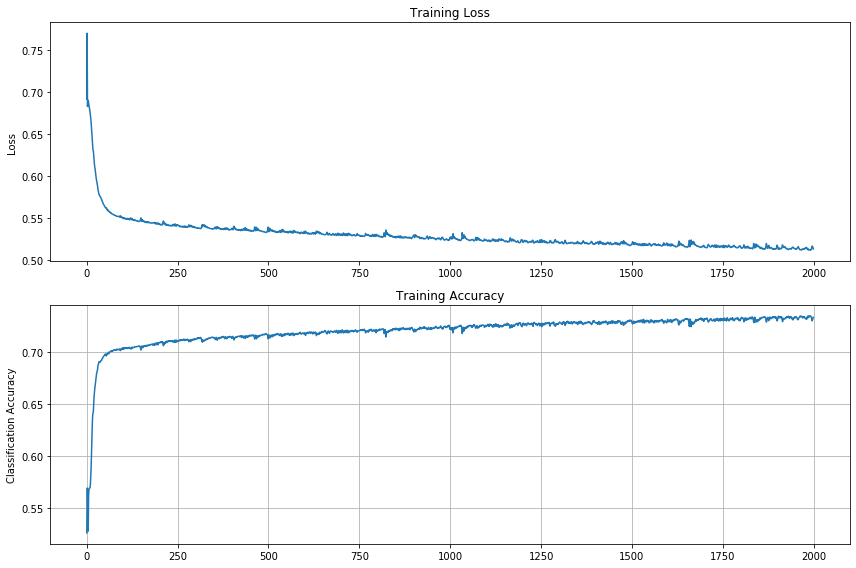

Test Accuracy 69.07%


In [14]:
net.plot_training_results()
net.output_accuracy(play_test.values, predict_test.values)

In [15]:
n_hidden_nodes = [1, 5, 10, 15, 25, 30, 50]

for n in n_hidden_nodes:
    print("Number of hidden nodes: {:d}".format(n))
    net = network(play_train.values, predict_train.values, n_hidden=n, device=device)
    net.train()
    net.plot_training_results()
    net.output_accuracy(play_test.values, predict_test.values)

Number of hidden nodes: 1


ZeroDivisionError: float division by zero

In [16]:
play_predict = net.predict(play_test.values)

[[80620 28396]
 [30956 52003]]


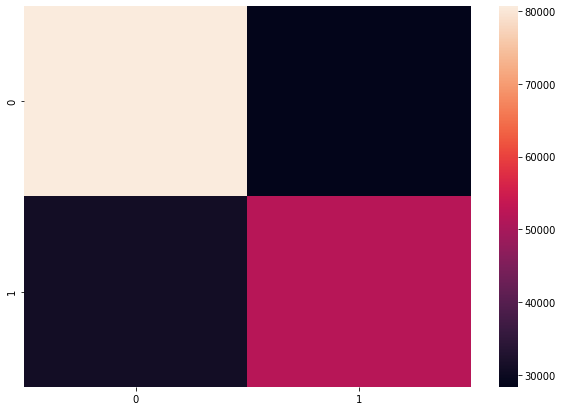

In [17]:
from sklearn.metrics import confusion_matrix
play_predict_hat = np.where(play_predict.cpu()<0.5, 0, 1)
confusion_matrix = confusion_matrix(predict_test.values, play_predict_hat)
print(confusion_matrix)

import seaborn as sns
plt.figure(figsize = (10,7))
sns.heatmap(confusion_matrix, annot=False)

In [153]:
from sklearn.metrics import classification_report
print(classification_report(predict_test, play_predict_hat))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73    109016
           1       0.64      0.64      0.64     82959

    accuracy                           0.69    191975
   macro avg       0.68      0.68      0.68    191975
weighted avg       0.69      0.69      0.69    191975



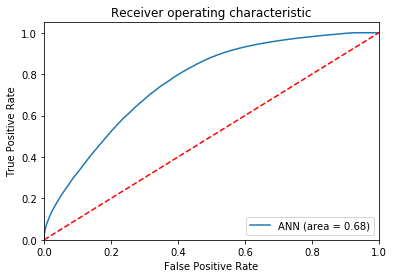

In [154]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
nn_probs = play_predict.cpu().detach()[:,0]
nn_roc_auc = roc_auc_score(predict_test, play_predict_hat)
fpr, tpr, thresholds = roc_curve(predict_test, nn_probs, pos_label=1)
plt.figure()
plt.plot(fpr, tpr, label='ANN (area = %0.2f)' % nn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [77]:
import shap

In [78]:
e = shap.DeepExplainer(net.net, play_test)
shap_values = e.shap_values(play_test)

AttributeError: 'DataFrame' object has no attribute 'dim'

In [155]:
out = np.concatenate((predict_test, play_predict_hat),axis=1)

In [156]:
test_df = pd.DataFrame(out)
test_df[0] = test_df[0] + 1
test_df[1] = test_df[1] + 1

In [157]:
test_df['correct'] = np.where(test_df[0] == test_df[1], 'yes', 'no')

In [158]:
agg_df = test_df.groupby([0,'correct']).count()
agg_df

1
0 correct       
1 no       29629
  yes      79387
2 no       29863
  yes      53096

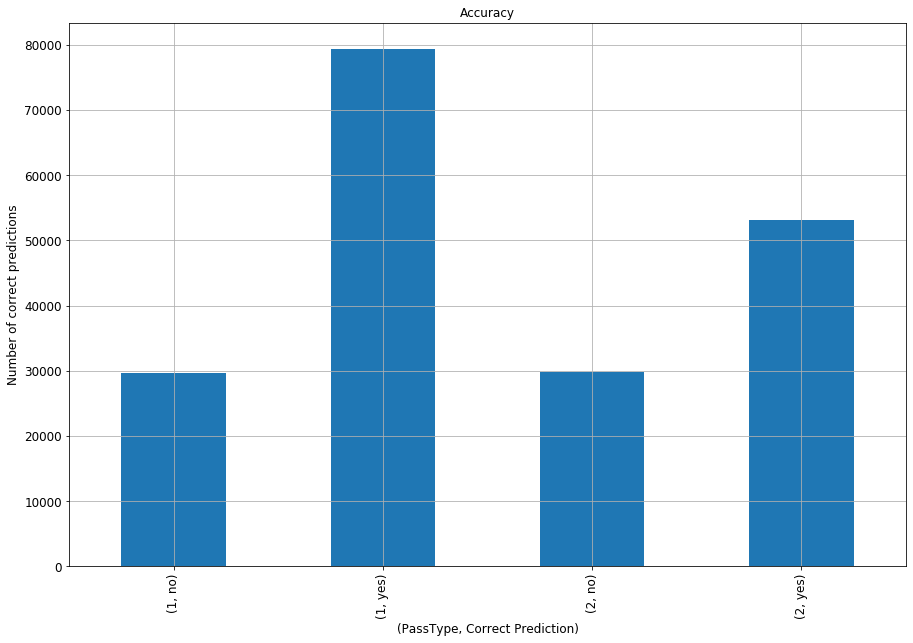

In [159]:
ax = agg_df.plot(kind='bar', title ="Accuracy", figsize=(15, 10), legend=False, fontsize=12)
ax.set_xlabel("(PassType, Correct Prediction)", fontsize=12)
ax.set_ylabel("Number of correct predictions", fontsize=12)
plt.grid(True)
plt.show()